In [4]:
# ====================================
# 1. Setup & Environment
# ====================================

# Note: Required packages are already installed in this environment.
# If running elsewhere, install with:
# %pip install -q transformers datasets accelerate scikit-learn pandas numpy tqdm

import os
import random
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

import matplotlib.pyplot as plt
from IPython.display import display

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoConfig,
    get_linear_schedule_with_warmup,
)

from datasets import load_dataset  # for real data

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optional: mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


/Users/varshithareddy/Library/Python/3.12/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [5]:
# ====================================
# 3. Data Format & Loading (REAL DATA)
# ====================================

# Updated for local execution - data will be saved in Downloads folder
DATA_PATH = "/Users/varshithareddy/Downloads/code_review_data_classification.csv"

# You can optionally subsample the dataset for faster experimentation.
# Set N_SAMPLES = None to use full data.
N_SAMPLES: int | None = None  # e.g., 5000 for a quick run

EXPECTED_LABELS = ["bug_fix", "refactor", "style", "docs", "tests", "perf", "other"]

# Map from source dataset labels to our 7-class label space
ccs_to_our_label = {
    "fix": "bug_fix",
    "refactor": "refactor",
    "style": "style",
    "docs": "docs",
    "test": "tests",
    "perf": "perf",
    # all others -> "other"
}

def build_df_from_hf() -> pd.DataFrame:
    """
    Build a DataFrame with schema:
        id, diff_text, commit_message, pr_title, label
    from a HuggingFace dataset with git diffs and commit types.
    """
    print("📥 Downloading real commit data from HuggingFace...")
    # Replace with another dataset if you like; this is just an example.
    ccs = load_dataset("0x404/ccs_dataset")  # has train / eval / test splits
    print(ccs)

    def split_to_df(split_name: str) -> pd.DataFrame:
        ds_split = ccs[split_name]
        df = ds_split.to_pandas()

        required_cols = ["sha", "git_diff", "commit_message", "annotated_type"]
        missing = [c for c in required_cols if c not in df.columns]
        if missing:
            raise ValueError(
                f"Expected columns {required_cols} in split '{split_name}', missing {missing}"
            )

        out = pd.DataFrame()
        out["id"] = df["sha"]
        out["diff_text"] = df["git_diff"]
        out["commit_message"] = df["commit_message"]
        # This dataset doesn't have PR titles; we leave them empty.
        out["pr_title"] = ""
        out["label"] = df["annotated_type"].map(lambda t: ccs_to_our_label.get(t, "other"))
        return out

    train_df = split_to_df("train")
    eval_df = split_to_df("eval")
    test_df = split_to_df("test")

    full_df = pd.concat([train_df, eval_df, test_df], ignore_index=True)
    full_df = full_df.dropna(subset=["label"]).reset_index(drop=True)

    if N_SAMPLES is not None and N_SAMPLES < len(full_df):
        full_df = full_df.sample(N_SAMPLES, random_state=SEED).reset_index(drop=True)
        print(f"🔎 Subsampled to {len(full_df)} rows for faster training.")

    return full_df


def load_or_create_real_data(data_path: str) -> pd.DataFrame:
    """
    If CSV exists at data_path, load it.
    Otherwise, build from HuggingFace dataset and save as CSV.
    """
    if os.path.exists(data_path):
        print(f"✅ Found existing dataset at: {data_path}")
        df = pd.read_csv(data_path)
    else:
        print(f"⚠️ Dataset not found at: {data_path}")
        df = build_df_from_hf()
        df.to_csv(data_path, index=False)
        print(f"✅ Saved new dataset to: {data_path}")

    required_cols = ["id", "diff_text", "commit_message", "pr_title", "label"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(
            f"❌ CSV missing required columns: {missing}\n"
            f"Expected at least: {required_cols}"
        )

    # Clean NaNs in text columns
    text_cols = ["diff_text", "commit_message", "pr_title"]
    for col in text_cols:
        df[col] = df[col].fillna("")

    print("\nDataset head:")
    display(df.head())

    print("\nLabel value counts:")
    print(df["label"].value_counts())

    return df


df = load_or_create_real_data(DATA_PATH)
print(f"\nFinal dataset shape: {df.shape}")


✅ Found existing dataset at: /Users/varshithareddy/Downloads/code_review_data_classification.csv

Dataset head:

Dataset head:


,id,diff_text,commit_message,pr_title,label
0,dec860436916ef216998f80f8b2f9c39d00c064d,diff --git a/topology/src/main/java/io/camunda...,refactor(topology): coordinator accepts a requ...,,other
1,a50b51999015e210918d9c8e95fd4cac347353be,diff --git a/src/content/redux/modules/diction...,style(content): remove unused,,refactor
2,d1f849e5d0813d27bcc4f99164796622d81d31cd,diff --git a/packages/compiler/experimental/ut...,feat: add dirty checker,,other
3,816b0d49c45f6669c5aae748396e9551f2e30a96,diff --git a/src/app/help.rs b/src/app/help.rs...,style: dis-`allow()` untriggered lints,,style
4,584470337a0ee82bfa92e43fac291bb8e5132fa0,diff --git a/ionic/components/action-sheet/act...,fix(alert): disable listeners until ready\n\nC...,,bug_fix



Label value counts:
label
other       800
refactor    200
style       200
bug_fix     200
docs        200
perf        200
tests       200
Name: count, dtype: int64

Final dataset shape: (2000, 5)


In [6]:
# ====================================
# 4. Train/Validation/Test Split (robust)
# ====================================

from sklearn.model_selection import train_test_split

def create_label_mappings(labels: List[str]) -> Tuple[Dict[str, int], Dict[int, str]]:
    unique_labels = sorted(set(labels))
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {idx: label for label, idx in label2id.items()}
    return label2id, id2label

label2id, id2label = create_label_mappings(df["label"].tolist())
num_labels = len(label2id)

print("Label to ID mapping:", label2id)
print("ID to Label mapping:", id2label)

def split_dataset(
    df: pd.DataFrame,
    val_size: float = 0.1,
    test_size: float = 0.1,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Robust split into train/val/test that:
    - Handles very small datasets.
    - Uses stratification only if every class has >= 2 samples.
    """
    n = len(df)
    if n < 3:
        print("⚠️ Dataset is very small (n < 3). Using all samples for train; val/test are empty.")
        return df.reset_index(drop=True), df.iloc[0:0].copy(), df.iloc[0:0].copy()

    # Determine if we can stratify based on class counts
    label_counts = df["label"].value_counts()
    can_stratify = label_counts.min() >= 2

    # First: split off test set
    if test_size > 0:
        test_size_abs = max(1, int(round(test_size * n)))  # at least 1 sample if possible
        test_size_rel = test_size_abs / n

        if can_stratify:
            print("Splitting train+val / test with stratification.")
            train_val_df, test_df = train_test_split(
                df,
                test_size=test_size_rel,
                stratify=df["label"],
                random_state=SEED,
            )
        else:
            print("Not enough samples per class to stratify; splitting train+val / test randomly.")
            train_val_df, test_df = train_test_split(
                df,
                test_size=test_size_rel,
                random_state=SEED,
            )
    else:
        train_val_df, test_df = df, df.iloc[0:0].copy()

    # Then: split train_val_df into train / val
    n_tv = len(train_val_df)
    if val_size > 0 and n_tv >= 2:
        val_size_abs = max(1, int(round(val_size * n)))  # relative to original size
        # but can't be larger than train_val_df
        val_size_abs = min(val_size_abs, n_tv - 1)
        val_size_rel = val_size_abs / n_tv

        label_counts_tv = train_val_df["label"].value_counts()
        can_stratify_tv = label_counts_tv.min() >= 2

        if can_stratify_tv:
            print("Splitting train / val with stratification.")
            train_df, val_df = train_test_split(
                train_val_df,
                test_size=val_size_rel,
                stratify=train_val_df["label"],
                random_state=SEED,
            )
        else:
            print("Not enough samples per class to stratify train/val; splitting randomly.")
            train_df, val_df = train_test_split(
                train_val_df,
                test_size=val_size_rel,
                random_state=SEED,
            )
    else:
        print("⚠️ Not enough samples to create a validation set; using all as train.")
        train_df, val_df = train_val_df, train_val_df.iloc[0:0].copy()

    return (
        train_df.reset_index(drop=True),
        val_df.reset_index(drop=True),
        test_df.reset_index(drop=True),
    )

train_df, val_df, test_df = split_dataset(df, val_size=0.1, test_size=0.1)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Label to ID mapping: {'bug_fix': 0, 'docs': 1, 'other': 2, 'perf': 3, 'refactor': 4, 'style': 5, 'tests': 6}
ID to Label mapping: {0: 'bug_fix', 1: 'docs', 2: 'other', 3: 'perf', 4: 'refactor', 5: 'style', 6: 'tests'}
Splitting train+val / test with stratification.
Splitting train / val with stratification.
Train size: 1600
Validation size: 200
Test size: 200


In [7]:
# ====================================
# 5. Tokenization & Dataset Class
# ====================================

MODEL_NAME = "microsoft/codebert-base"  # can switch to "roberta-base" if needed
MAX_LENGTH = 256
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# Ensure we have a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token or tokenizer.unk_token
    print(f"Tokenizer pad_token set to: {tokenizer.pad_token} (id={tokenizer.pad_token_id})")

class CodeReviewDataset(Dataset):
    """
    PyTorch Dataset for code review classification.
    """

    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_length: int,
        label2id: Dict[str, int],
    ):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label2id = label2id

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        row = self.df.iloc[idx]
        diff_text = str(row.get("diff_text", ""))
        commit_message = str(row.get("commit_message", ""))
        pr_title = str(row.get("pr_title", ""))

        combined_text = f"DIFF: {diff_text} COMMIT: {commit_message} TITLE: {pr_title}"

        encoding = self.tokenizer(
            combined_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )

        label_str = str(row["label"])
        label_id = self.label2id[label_str]

        item = {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label_id, dtype=torch.long),
        }
        return item


def create_dataloaders(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_length: int,
    label2id: Dict[str, int],
    batch_size: int = 8,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = CodeReviewDataset(train_df, tokenizer, max_length, label2id)
    val_dataset = CodeReviewDataset(val_df, tokenizer, max_length, label2id)
    test_dataset = CodeReviewDataset(test_df, tokenizer, max_length, label2id)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = create_dataloaders(
    train_df,
    val_df,
    test_df,
    tokenizer,
    MAX_LENGTH,
    label2id,
    BATCH_SIZE,
)

print("Dataloaders created.")


Dataloaders created.


In [8]:
# ====================================
# 6. Baseline BiLSTM/GRU Classifier
# ====================================

class AttentionPooling(nn.Module):
    """
    Simple attention mechanism that produces a weighted sum
    over sequence outputs.
    """

    def __init__(self, hidden_dim: int):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        encoder_outputs: (batch, seq_len, hidden_dim)
        mask: (batch, seq_len) with 1 for valid tokens, 0 for padding
        """
        scores = self.attn(encoder_outputs).squeeze(-1)  # (batch, seq_len)
        scores = scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(scores, dim=-1)     # (batch, seq_len)
        context = torch.sum(encoder_outputs * attn_weights.unsqueeze(-1), dim=1)
        return context


class BiLSTMClassifier(nn.Module):
    """
    Baseline classifier using BiLSTM + attention.
    """

    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        hidden_dim: int,
        num_labels: int,
        pad_token_id: int,
        num_layers: int = 1,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_token_id,
        )

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        self.attention = AttentionPooling(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
    ) -> torch.Tensor:
        """
        input_ids: (batch, seq_len)
        attention_mask: (batch, seq_len)
        """
        embedded = self.embedding(input_ids)      # (batch, seq_len, embed_dim)
        outputs, _ = self.lstm(embedded)          # (batch, seq_len, 2*hidden_dim)
        context = self.attention(outputs, attention_mask)  # (batch, 2*hidden_dim)
        context = self.dropout(context)
        logits = self.classifier(context)         # (batch, num_labels)
        return logits


vocab_size = tokenizer.vocab_size
pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0

baseline_model = BiLSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=256,
    hidden_dim=256,
    num_labels=num_labels,
    pad_token_id=pad_token_id,
    num_layers=1,
    dropout=0.2,
).to(device)

print(baseline_model)


BiLSTMClassifier(
  (embedding): Embedding(50265, 256, padding_idx=1)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (attention): AttentionPooling(
    (attn): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=512, out_features=7, bias=True)
)


In [9]:
# ====================================
# 7. Transformer: CodeBERT Classifier
# ====================================

class CodeBertClassifier(nn.Module):
    """
    Transformer-based classifier using CodeBERT (or Roberta-like models).
    """

    def __init__(self, model_name: str, num_labels: int, dropout: float = 0.1):
        super().__init__()
        self.config = AutoConfig.from_pretrained(
            model_name,
            num_labels=num_labels,
        )
        self.transformer = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
    ) -> torch.Tensor:
        """
        input_ids: (batch, seq_len)
        attention_mask: (batch, seq_len)
        """
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        last_hidden_state = outputs.last_hidden_state   # (batch, seq_len, hidden)
        cls_rep = last_hidden_state[:, 0, :]            # (batch, hidden)

        cls_rep = self.dropout(cls_rep)
        logits = self.classifier(cls_rep)               # (batch, num_labels)
        return logits


transformer_model = CodeBertClassifier(MODEL_NAME, num_labels=num_labels, dropout=0.1).to(device)
print(transformer_model)


CodeBertClassifier(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [10]:
# ====================================
# 8. Training Utilities (robust saving)
# ====================================

def compute_metrics(
    y_true: List[int],
    y_pred: List[int],
    average: str = "macro",
) -> Dict[str, float]:
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average=average,
        zero_division=0,
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


def train_one_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    scheduler=None,
) -> Tuple[float, Dict[str, float]]:
    model.train()
    criterion = nn.CrossEntropyLoss()

    all_preds: List[int] = []
    all_labels: List[int] = []

    running_loss = 0.0
    num_batches = 0

    for batch in tqdm(data_loader, desc="Training", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item()
        num_batches += 1

        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.detach().cpu().tolist())
        all_labels.extend(labels.detach().cpu().tolist())

    avg_loss = running_loss / max(1, num_batches)
    metrics = compute_metrics(all_labels, all_preds)
    return avg_loss, metrics


def evaluate_model(
    model: nn.Module,
    data_loader: DataLoader,
    device: torch.device,
) -> Tuple[float, Dict[str, float]]:
    model.eval()
    criterion = nn.CrossEntropyLoss()

    all_preds: List[int] = []
    all_labels: List[int] = []

    running_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            running_loss += loss.item()
            num_batches += 1

            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.detach().cpu().tolist())
            all_labels.extend(labels.detach().cpu().tolist())

    avg_loss = running_loss / max(1, num_batches)
    metrics = compute_metrics(all_labels, all_preds)
    return avg_loss, metrics


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    num_epochs: int,
    scheduler=None,
    model_name: str = "model",
) -> Dict[str, float]:
    """
    Train model and ALWAYS save at least one checkpoint.

    - best_f1 starts at -1.0 so first epoch will always be "best".
    - After training, if somehow no file exists, we save the final model.
    """
    best_f1 = -1.0
    best_model_path = f"best_{model_name}.pt"
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    for epoch in range(1, num_epochs + 1):
        print(f"\n===== Epoch {epoch}/{num_epochs} – {model_name} =====")

        train_loss, train_metrics = train_one_epoch(
            model, train_loader, optimizer, device, scheduler
        )
        val_loss, val_metrics = evaluate_model(model, val_loader, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_f1"].append(val_metrics["f1"])

        print(
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_metrics['accuracy']:.4f} | "
            f"Val F1 (macro): {val_metrics['f1']:.4f}"
        )

        # Save if F1 improves (>= to catch first epoch when best_f1 = -1.0)
        if val_metrics["f1"] >= best_f1:
            best_f1 = val_metrics["f1"]
            torch.save(model.state_dict(), best_model_path)
            print(f"✅ New best model saved to {best_model_path} (F1={best_f1:.4f})")

    # Safety: ensure the file exists
    if not os.path.exists(best_model_path):
        torch.save(model.state_dict(), best_model_path)
        print(f"⚠️ No best model was saved during training; saved final model to {best_model_path} instead.")

    print(f"\nBest Val F1 for {model_name}: {best_f1:.4f}")
    return {
        "best_f1": best_f1,
        "best_model_path": best_model_path,
        "history": history,
    }


def load_model_weights(model: nn.Module, path: str, device: torch.device) -> nn.Module:
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Model checkpoint not found at {path}. "
            "Make sure you have run training and that a checkpoint was saved."
        )
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print(f"Loaded model weights from {path}")
    return model


In [11]:
# ====================================
# 8.1 Train Baseline Model
# ====================================

BASELINE_EPOCHS = 3  # Increase for real training runs if you have time/GPU

baseline_model = baseline_model.to(device)

baseline_optimizer = torch.optim.AdamW(
    baseline_model.parameters(),
    lr=1e-3,
)

baseline_result = train_model(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=baseline_optimizer,
    device=device,
    num_epochs=BASELINE_EPOCHS,
    scheduler=None,
    model_name="baseline",
)

print("\nBaseline model best Val F1:", baseline_result["best_f1"])



===== Epoch 1/3 – baseline =====


Train Loss: 1.4119 | Val Loss: 1.0897 | Val Acc: 0.6200 | Val F1 (macro): 0.4677
✅ New best model saved to best_baseline.pt (F1=0.4677)

===== Epoch 2/3 – baseline =====


Train Loss: 1.1334 | Val Loss: 1.0577 | Val Acc: 0.6250 | Val F1 (macro): 0.4932
✅ New best model saved to best_baseline.pt (F1=0.4932)

===== Epoch 3/3 – baseline =====


Train Loss: 0.9532 | Val Loss: 1.0602 | Val Acc: 0.6300 | Val F1 (macro): 0.5221
✅ New best model saved to best_baseline.pt (F1=0.5221)

Best Val F1 for baseline: 0.5221

Baseline model best Val F1: 0.5220942106062723


In [26]:
# ====================================
# 8.2 Train Transformer Model (CodeBERT)
# ====================================

TRANSFORMER_EPOCHS = 3  # Increased from 1 to 3 for better accuracy

transformer_model = transformer_model.to(device)

num_training_steps = TRANSFORMER_EPOCHS * len(train_loader)

transformer_optimizer = torch.optim.AdamW(
    transformer_model.parameters(),
    lr=2e-5,
)

scheduler = get_linear_schedule_with_warmup(
    transformer_optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)

transformer_result = train_model(
    model=transformer_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=transformer_optimizer,
    device=device,
    num_epochs=TRANSFORMER_EPOCHS,
    scheduler=scheduler,
    model_name="codebert",
)

print("\nTransformer (CodeBERT) best Val F1:", transformer_result["best_f1"])

print("\n=== Summary of Best Validation F1 Scores ===")
print(f"Baseline BiLSTM:      {baseline_result['best_f1']:.4f}")
print(f"Transformer CodeBERT: {transformer_result['best_f1']:.4f}")



===== Epoch 1/3 – codebert =====


Train Loss: 1.3570 | Val Loss: 1.1966 | Val Acc: 0.5650 | Val F1 (macro): 0.4279
✅ New best model saved to best_codebert.pt (F1=0.4279)

===== Epoch 2/3 – codebert =====
✅ New best model saved to best_codebert.pt (F1=0.4279)

===== Epoch 2/3 – codebert =====


Train Loss: 1.1262 | Val Loss: 1.0470 | Val Acc: 0.6450 | Val F1 (macro): 0.5239
✅ New best model saved to best_codebert.pt (F1=0.5239)

===== Epoch 3/3 – codebert =====
✅ New best model saved to best_codebert.pt (F1=0.5239)

===== Epoch 3/3 – codebert =====


Train Loss: 0.9582 | Val Loss: 1.0142 | Val Acc: 0.6500 | Val F1 (macro): 0.5550
✅ New best model saved to best_codebert.pt (F1=0.5550)

Best Val F1 for codebert: 0.5550

Transformer (CodeBERT) best Val F1: 0.5549650327510837

=== Summary of Best Validation F1 Scores ===
Baseline BiLSTM:      0.5221
Transformer CodeBERT: 0.5550
✅ New best model saved to best_codebert.pt (F1=0.5550)

Best Val F1 for codebert: 0.5550

Transformer (CodeBERT) best Val F1: 0.5549650327510837

=== Summary of Best Validation F1 Scores ===
Baseline BiLSTM:      0.5221
Transformer CodeBERT: 0.5550


✅ Found checkpoint at best_codebert.pt, loading it.
Loaded model weights from best_codebert.pt
Loaded model weights from best_codebert.pt



=== Test Set Metrics (CodeBERT) ===
Test Loss: 1.1349
Accuracy:  0.6400
Precision: 0.5773
Recall:    0.5714
F1 (macro):0.5473



Classification Report (CodeBERT on Test Set):
              precision    recall  f1-score   support

     bug_fix       0.35      0.45      0.39        20
        docs       0.68      0.65      0.67        20
       other       0.79      0.80      0.80        80
        perf       0.52      0.75      0.61        20
    refactor       0.33      0.20      0.25        20
       style       0.67      0.20      0.31        20
       tests       0.70      0.95      0.81        20

    accuracy                           0.64       200
   macro avg       0.58      0.57      0.55       200
weighted avg       0.64      0.64      0.62       200



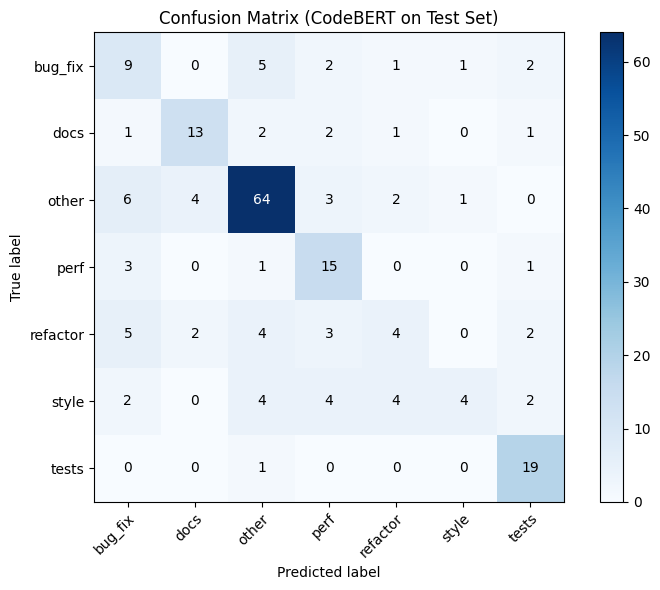

In [27]:
# ====================================
# 9. Evaluation on Test Set (robust)
# ====================================

BEST_TRANSFORMER_PATH = transformer_result["best_model_path"]

# Either load from checkpoint, or fall back to the in-memory model
if os.path.exists(BEST_TRANSFORMER_PATH):
    print(f"✅ Found checkpoint at {BEST_TRANSFORMER_PATH}, loading it.")
    best_transformer = CodeBertClassifier(MODEL_NAME, num_labels=num_labels, dropout=0.1)
    best_transformer = load_model_weights(best_transformer, BEST_TRANSFORMER_PATH, device)
else:
    print(f"⚠️ Checkpoint {BEST_TRANSFORMER_PATH} not found.")
    print("   Using the current in-memory transformer_model for evaluation instead.")
    best_transformer = transformer_model.to(device)
    best_transformer.eval()

# Evaluate on test set (overall metrics)
test_loss, test_metrics = evaluate_model(best_transformer, test_loader, device)

print("\n=== Test Set Metrics (CodeBERT) ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1 (macro):{test_metrics['f1']:.4f}")

# Collect predictions for detailed report
best_transformer.eval()
all_preds: List[int] = []
all_labels: List[int] = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Inference", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = best_transformer(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.detach().cpu().tolist())
        all_labels.extend(labels.detach().cpu().tolist())

# If test set is empty, avoid crashing
if len(all_labels) == 0:
    print("\n⚠️ Test set is empty; skipping classification_report and confusion matrix.")
else:
    print("\nClassification Report (CodeBERT on Test Set):")
    # Explicitly specify labels and target_names so sklearn doesn't get confused
    labels_for_report = list(range(num_labels))
    target_names_for_report = [id2label[i] for i in labels_for_report]

    print(
        classification_report(
            all_labels,
            all_preds,
            labels=labels_for_report,
            target_names=target_names_for_report,
            zero_division=0,
        )
    )

    cm = confusion_matrix(
        all_labels,
        all_preds,
        labels=labels_for_report,
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=target_names_for_report,
        yticklabels=target_names_for_report,
        ylabel="True label",
        xlabel="Predicted label",
        title="Confusion Matrix (CodeBERT on Test Set)",
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.0 if cm.size > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.show()


In [30]:
# ====================================
# 10. Inference Demo Cell
# ====================================

def predict_single(
    model: nn.Module,
    tokenizer: AutoTokenizer,
    diff_text: str,
    commit_message: str,
    pr_title: str,
    label_map: Dict[int, str],
    max_length: int = 256,
) -> Tuple[str, Dict[str, float]]:
    model.eval()

    combined_text = f"DIFF: {diff_text} COMMIT: {commit_message} TITLE: {pr_title}"

    encoding = tokenizer(
        combined_text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()

    pred_id = int(np.argmax(probs))
    pred_label = label_map[pred_id]

    prob_dict = {
        label_map[i]: float(probs[i]) for i in range(len(probs))
    }

    return pred_label, prob_dict


# Example inputs (you can edit these)
example_diff = """
- user = get_user(id)
+ user = get_user_by_id(user_id)
+ if user is None:
+     raise UserNotFoundError(user_id)
"""

example_commit_message = "Fix user retrieval and handle missing user"
example_pr_title = "Bug fix: user retrieval edge cases"

print("🔍 Running inference with example diff...")

pred_label, prob_dict = predict_single(
    model=best_transformer,
    tokenizer=tokenizer,
    diff_text=example_diff,
    commit_message=example_commit_message,
    pr_title=example_pr_title,
    label_map=id2label,
    max_length=MAX_LENGTH,
)

print("\nPredicted label:", pred_label)
print("\nClass probabilities:")
for label, prob in sorted(prob_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:10s}: {prob:.4f}")


🔍 Running inference with example diff...

Predicted label: other

Class probabilities:
  other     : 0.3498
  docs      : 0.3182
  perf      : 0.0931
  refactor  : 0.0911
  style     : 0.0811
  bug_fix   : 0.0482
  tests     : 0.0185

Predicted label: other

Class probabilities:
  other     : 0.3498
  docs      : 0.3182
  perf      : 0.0931
  refactor  : 0.0911
  style     : 0.0811
  bug_fix   : 0.0482
  tests     : 0.0185


In [31]:
# ====================================
# 10.1 Interactive Inference (Optional)
# ====================================

# You can run this cell to provide custom input in Colab
try:
    use_custom = input("Do you want to enter a custom diff? (y/n): ").strip().lower()
    if use_custom == "y":
        print("\nPaste diff_text (you can include multiple lines). Finish with Enter:")
        user_diff_lines = []
        while True:
            line = input()
            if line.strip() == "":
                break
            user_diff_lines.append(line)
        user_diff = "\n".join(user_diff_lines)

        user_commit = input("\nEnter commit_message (optional): ")
        user_title = input("\nEnter pr_title (optional): ")

        pred_label, prob_dict = predict_single(
            model=best_transformer,
            tokenizer=tokenizer,
            diff_text=user_diff,
            commit_message=user_commit,
            pr_title=user_title,
            label_map=id2label,
            max_length=MAX_LENGTH,
        )

        print("\nPredicted label:", pred_label)
        print("\nClass probabilities:")
        for label, prob in sorted(prob_dict.items(), key=lambda x: x[1], reverse=True):
            print(f"  {label:10s}: {prob:.4f}")
    else:
        print("Skipping interactive inference. You can re-run this cell later.")
except EOFError:
    # In non-interactive environments this may fail
    print("Interactive input not available in this environment.")


Skipping interactive inference. You can re-run this cell later.


In [34]:
# ====================================
# 10.1 Prediction helper (classification only)
# ====================================

def predict_single(
    model: nn.Module,
    tokenizer: AutoTokenizer,
    diff_text: str,
    commit_message: str,
    pr_title: str,
    label_map: Dict[int, str],
    max_length: int = 256,
) -> Tuple[str, Dict[str, float]]:
    """
    Run the transformer model on a single (diff, commit_message, pr_title)
    and return:
      - predicted label (string)
      - probability dict {label -> prob}
    """
    model.eval()

    combined_text = f"DIFF: {diff_text} COMMIT: {commit_message} TITLE: {pr_title}"

    encoding = tokenizer(
        combined_text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=-1).squeeze(0).cpu().numpy()

    pred_id = int(np.argmax(probs))
    pred_label = label_map[pred_id]

    prob_dict = {
        label_map[i]: float(probs[i]) for i in range(len(probs))
    }

    return pred_label, prob_dict


In [48]:
# ====================================
# 10.2 Turn prediction into a code review-style comment (INTELLIGENT VERSION)
# ====================================

import re

def parse_diff_changes(diff_text: str) -> Dict[str, any]:
    """
    Parse a git diff to extract meaningful information about the changes.
    Returns a dict with:
      - files_changed: list of file paths
      - additions: number of added lines
      - deletions: number of deleted lines
      - new_files: list of newly created files
      - modified_functions: list of function names that were modified
      - has_tests: whether test files were added/modified
      - has_docstrings: whether docstrings were added
      - has_type_hints: whether type hints were added
      - error_handling: whether exception handling was added
      - key_changes: list of notable changes
    """
    result = {
        'files_changed': [],
        'additions': 0,
        'deletions': 0,
        'new_files': [],
        'modified_functions': [],
        'has_tests': False,
        'has_docstrings': False,
        'has_type_hints': False,
        'error_handling': [],
        'key_changes': []
    }
    
    lines = diff_text.split('\n')
    current_file = None
    
    for line in lines:
        # Track file changes
        if line.startswith('diff --git'):
            match = re.search(r'b/(.+)$', line)
            if match:
                current_file = match.group(1)
                result['files_changed'].append(current_file)
        
        # New files
        elif line.startswith('new file mode'):
            if current_file:
                result['new_files'].append(current_file)
        
        # Count additions/deletions
        elif line.startswith('+') and not line.startswith('+++'):
            result['additions'] += 1
            
            # Check for specific patterns
            if '"""' in line or "'''" in line:
                result['has_docstrings'] = True
            if '->' in line and ('def ' in line or 'int' in line or 'str' in line or 'bool' in line or 'float' in line):
                result['has_type_hints'] = True
            if 'except' in line or 'try:' in line or 'raise' in line:
                # Extract exception type
                exc_match = re.search(r'except\s+(\w+)', line)
                if exc_match:
                    result['error_handling'].append(exc_match.group(1))
                elif 'raise' in line:
                    exc_match = re.search(r'raise\s+(\w+)', line)
                    if exc_match:
                        result['error_handling'].append(exc_match.group(1))
            
        elif line.startswith('-') and not line.startswith('---'):
            result['deletions'] += 1
        
        # Track function modifications
        if line.startswith('@@'):
            func_match = re.search(r'def\s+(\w+)', line)
            if func_match:
                result['modified_functions'].append(func_match.group(1))
    
    # Check for test files
    result['has_tests'] = any('test' in f.lower() for f in result['files_changed'])
    
    # Generate key changes summary
    if result['new_files']:
        result['key_changes'].append(f"Created {len(result['new_files'])} new file(s): {', '.join(result['new_files'][:3])}")
    if result['has_type_hints']:
        result['key_changes'].append("Added type hints for better type safety")
    if result['has_docstrings']:
        result['key_changes'].append("Added documentation/docstrings")
    if result['error_handling']:
        unique_errors = list(set(result['error_handling']))[:3]
        result['key_changes'].append(f"Added error handling for: {', '.join(unique_errors)}")
    if result['has_tests']:
        result['key_changes'].append("Includes test coverage")
    
    return result


def generate_code_review_comment(
    diff_text: str,
    commit_message: str,
    pr_title: str,
    pred_label: str,
    prob_dict: Dict[str, float],
    top_k: int = 3,
) -> str:
    """
    Generate an intelligent, diff-aware code review comment.
    Analyzes the actual code changes and provides specific feedback.
    """
    
    # Parse the diff to understand changes
    diff_info = parse_diff_changes(diff_text)
    
    # Extract top-K probabilities for transparency
    sorted_probs = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
    top_labels = ", ".join([f"{lbl}={prob:.2f}" for lbl, prob in sorted_probs[:top_k]])
    
    review_lines: List[str] = []
    review_lines.append("=== AI Code Review ===\n")
    
    # Context section
    if pr_title or commit_message:
        review_lines.append("**Context**")
        if pr_title:
            review_lines.append(f"- PR Title: {pr_title}")
        if commit_message:
            review_lines.append(f"- Commit: {commit_message}")
        review_lines.append("")
    
    # Classification result
    review_lines.append("**Change Classification**")
    review_lines.append(f"- Type: `{pred_label}` (confidence: {sorted_probs[0][1]:.0%})")
    review_lines.append(f"- Alternatives: {', '.join([f'{lbl} ({prob:.0%})' for lbl, prob in sorted_probs[1:top_k]])}")
    review_lines.append("")
    
    # Summary of changes
    review_lines.append("**Change Summary**")
    review_lines.append(f"- Files modified: {len(diff_info['files_changed'])}")
    review_lines.append(f"- Lines added: +{diff_info['additions']}, removed: -{diff_info['deletions']}")
    if diff_info['key_changes']:
        review_lines.append("\nKey changes detected:")
        for change in diff_info['key_changes']:
            review_lines.append(f"  • {change}")
    review_lines.append("")
    
    # Specific review based on label and actual changes
    review_lines.append("**Review Comments**")
    
    if pred_label == "bug_fix":
        review_lines.append("✓ This appears to be a **bug fix**.")
        if diff_info['error_handling']:
            review_lines.append(f"✓ Good: Added error handling for {', '.join(set(diff_info['error_handling'])[:2])}")
        if not diff_info['has_tests']:
            review_lines.append("⚠ Consider: Adding regression tests to prevent this bug from recurring")
        else:
            review_lines.append("✓ Good: Test coverage included")
        review_lines.append("• Verify edge cases are properly handled (null/None, empty values, boundary conditions)")
        
    elif pred_label == "refactor":
        review_lines.append("✓ This appears to be a **refactoring** change.")
        review_lines.append("• Ensure behavior is preserved - no functional changes")
        if diff_info['has_type_hints']:
            review_lines.append("✓ Good: Type hints improve code quality")
        if diff_info['has_docstrings']:
            review_lines.append("✓ Good: Documentation updated")
        if not diff_info['has_tests']:
            review_lines.append("⚠ Consider: Adding tests to verify behavior hasn't changed")
        else:
            review_lines.append("✓ Good: Tests verify refactoring didn't break functionality")
            
    elif pred_label == "tests":
        review_lines.append("✓ This change adds/modifies **tests**.")
        test_count = sum(1 for f in diff_info['files_changed'] if 'test' in f.lower())
        review_lines.append(f"• Test files modified: {test_count}")
        review_lines.append("• Verify tests cover both happy path and edge cases")
        review_lines.append("• Ensure test names clearly describe what's being tested")
        if diff_info['error_handling']:
            review_lines.append("✓ Good: Tests include error/exception scenarios")
            
    elif pred_label == "perf":
        review_lines.append("✓ This appears to be a **performance** optimization.")
        review_lines.append("⚠ Important: Include before/after benchmarks (latency, memory, throughput)")
        review_lines.append("• Watch for readability vs performance trade-offs")
        if diff_info['has_tests']:
            review_lines.append("✓ Good: Tests verify correctness is maintained")
        else:
            review_lines.append("⚠ Consider: Adding performance benchmarks as tests")
            
    elif pred_label == "style":
        review_lines.append("✓ This change focuses on **code style/formatting**.")
        review_lines.append(f"• {diff_info['additions'] + diff_info['deletions']} lines affected")
        review_lines.append("• Ensure changes follow project linting rules")
        review_lines.append("• Consider separating style changes from logic changes in future PRs")
        
    elif pred_label == "docs":
        review_lines.append("✓ This is a **documentation** update.")
        if diff_info['has_docstrings']:
            review_lines.append("✓ Good: Docstrings added/updated")
        review_lines.append("• Verify documentation accurately reflects current behavior")
        review_lines.append("• Check for typos and clarity")
        if any('.md' in f or 'README' in f for f in diff_info['files_changed']):
            review_lines.append("✓ Good: README/markdown documentation updated")
            
    else:  # "other" or mixed changes
        review_lines.append("ℹ This change appears to be **mixed/other** type.")
        review_lines.append(f"• Affects {len(diff_info['files_changed'])} file(s) with diverse changes")
        review_lines.append("⚠ Consider: Splitting into focused, single-purpose PRs for easier review")
        review_lines.append("• Add more context in the PR description about the intent")
    
    review_lines.append("")
    review_lines.append("---")
    review_lines.append("_🤖 This review was generated by an AI code classifier. Always apply human judgment._")
    
    return "\n".join(review_lines)

In [58]:
# ====================================
# 10.3 Example: code in, review out
# ====================================

example_diff = """
diff --git a/user_service.py b/user_service.py
index 1234567..89abcde 100644
--- a/user_service.py
+++ b/user_service.py
@@ -10,9 +10,14 @@ class UserService:
-    def get_user(self, id):
-        user = self.repo.get(id)
-        return user.name
+    def get_user(self, user_id: int) -> str:
+        user = self.repo.get(user_id)
+        if user is None:
+            # Fix: handle missing user instead of crashing
+            raise UserNotFoundError(user_id)
+        return user.name

-    def delete_user(self, id):
-        self.repo.delete(id)
+    def delete_user(self, user_id: int) -> None:
+        # Refactor: use new logging helper
+        self.logger.info(f"Deleting user {user_id}")
+        self.repo.delete(user_id)
""".strip()

example_commit_message = "Fix crash when user is missing and improve delete logging"
example_pr_title = "Bug fix: handle missing users safely"

pred_label, prob_dict = predict_single(
    model=best_transformer,
    tokenizer=tokenizer,
    diff_text=example_diff,
    commit_message=example_commit_message,
    pr_title=example_pr_title,
    label_map=id2label,
    max_length=MAX_LENGTH,
)

review_text = generate_code_review_comment(
    diff_text=example_diff,
    commit_message=example_commit_message,
    pr_title=example_pr_title,
    pred_label=pred_label,
    prob_dict=prob_dict,
)

print(review_text)


=== AI Code Review ===

**Context**
- PR Title: Bug fix: handle missing users safely
- Commit: Fix crash when user is missing and improve delete logging

**Change Classification**
- Type: `perf` (confidence: 50%)
- Alternatives: bug_fix (26%), refactor (9%)

**Change Summary**
- Files modified: 1
- Lines added: +10, removed: -5

Key changes detected:
  • Added type hints for better type safety
  • Added error handling for: UserNotFoundError

**Review Comments**
✓ This appears to be a **performance** optimization.
⚠ Important: Include before/after benchmarks (latency, memory, throughput)
• Watch for readability vs performance trade-offs
⚠ Consider: Adding performance benchmarks as tests

---
_🤖 This review was generated by an AI code classifier. Always apply human judgment._


In [59]:
# ====================================
# 10.4 Second Example: code in, review out
# ====================================

example_diff_2 = """
diff --git a/payment_service.py b/payment_service.py
index 1122334..a1b2c3d 100644
--- a/payment_service.py
+++ b/payment_service.py
@@ -5,18 +5,33 @@ class PaymentService:
-    def charge(self, user_id, amount):
-        if amount <= 0:
-            raise Exception("invalid amount")
-        try:
-            self.gateway.charge(user_id, amount)
-        except Exception as e:
-            print("Error charging user:", e)
-            raise
+    def charge(self, user_id: str, amount: float) -> bool:
+        \"\"\"Charge the given user. Returns True on success, False on failure.\"\"\"
+        if amount <= 0:
+            raise ValueError(f\"Amount must be positive, got {amount}\")
+
+        try:
+            self.logger.info("Charging user %s for %.2f", user_id, amount)
+            self.gateway.charge(user_id, amount)
+        except GatewayTimeoutError as e:
+            self.logger.warning("Gateway timeout while charging user %s: %s", user_id, e)
+            return False
+        except Exception as e:
+            self.logger.error("Unexpected error while charging user %s: %s", user_id, e)
+            raise
+        else:
+            self.logger.info("Successfully charged user %s", user_id)
+            return True

diff --git a/tests/test_payment_service.py b/tests/test_payment_service.py
new file mode 100644
index 0000000..d4e5f6a
--- /dev/null
+++ b/tests/test_payment_service.py
@@ -0,0 +1,32 @@
+import pytest
+from payment_service import PaymentService, GatewayTimeoutError
+
+
+def test_charge_raises_on_non_positive_amount(fake_gateway, fake_logger):
+    svc = PaymentService(fake_gateway, fake_logger)
+    with pytest.raises(ValueError):
+        svc.charge("user-123", 0.0)
+
+
+def test_charge_returns_false_on_timeout(fake_gateway_timeout, fake_logger):
+    svc = PaymentService(fake_gateway_timeout, fake_logger)
+    assert svc.charge("user-123", 10.0) is False
+
+
+def test_charge_returns_true_on_success(fake_gateway, fake_logger):
+    svc = PaymentService(fake_gateway, fake_logger)
+    assert svc.charge("user-123", 10.0) is True
""".strip()

example_commit_message_2 = "Refactor payment charging logic and add unit tests"
example_pr_title_2 = "Refactor: improve PaymentService charge() and test coverage"

pred_label_2, prob_dict_2 = predict_single(
    model=best_transformer,
    tokenizer=tokenizer,
    diff_text=example_diff_2,
    commit_message=example_commit_message_2,
    pr_title=example_pr_title_2,
    label_map=id2label,
    max_length=MAX_LENGTH,
)

review_text_2 = generate_code_review_comment(
    diff_text=example_diff_2,
    commit_message=example_commit_message_2,
    pr_title=example_pr_title_2,
    pred_label=pred_label_2,
    prob_dict=prob_dict_2,
)

print(review_text_2)


=== AI Code Review ===

**Context**
- PR Title: Refactor: improve PaymentService charge() and test coverage
- Commit: Refactor payment charging logic and add unit tests

**Change Classification**
- Type: `perf` (confidence: 47%)
- Alternatives: bug_fix (25%), style (10%)

**Change Summary**
- Files modified: 2
- Lines added: +35, removed: -8

Key changes detected:
  • Created 1 new file(s): tests/test_payment_service.py
  • Added type hints for better type safety
  • Added documentation/docstrings
  • Added error handling for: ValueError, GatewayTimeoutError, Exception
  • Includes test coverage

**Review Comments**
✓ This appears to be a **performance** optimization.
⚠ Important: Include before/after benchmarks (latency, memory, throughput)
• Watch for readability vs performance trade-offs
✓ Good: Tests verify correctness is maintained

---
_🤖 This review was generated by an AI code classifier. Always apply human judgment._


In [60]:
# ====================================
# 10.5 Third Example: Documentation Update
# ====================================

example_diff_3 = """
diff --git a/README.md b/README.md
index abc1234..def5678 100644
--- a/README.md
+++ b/README.md
@@ -1,10 +1,25 @@
 # User Management API
 
-Simple API for managing users.
+A RESTful API for managing user accounts with authentication and authorization.

+## Features
+
+- User registration and authentication
+- Role-based access control (RBAC)
+- Password reset functionality
+- Email verification
+
 ## Installation

-pip install requirements.txt
+```bash
+pip install -r requirements.txt
+python manage.py migrate
+python manage.py runserver
+```

 ## Usage

-See the code.
+### Creating a User
+
+```python
+from user_service import UserService
+
+service = UserService()
+user = service.create_user(email="test@example.com", password="secure123")
+```
+
+### Authentication
+
+Send POST request to `/api/auth/login` with email and password.

diff --git a/api/user_service.py b/api/user_service.py
index 9876543..1234abc 100644
--- a/api/user_service.py
+++ b/api/user_service.py
@@ -5,6 +5,14 @@ from typing import Optional
 
 class UserService:
+    \"\"\"
+    Service class for managing user accounts.
+    
+    Provides methods for user creation, authentication, and management.
+    All methods validate input and handle errors appropriately.
+    
+    Example:
+        >>> service = UserService()
+        >>> user = service.create_user(email="test@example.com")
+    \"\"\"
+    
     def create_user(self, email: str, password: str) -> User:
+        \"\"\"Create a new user account with the given email and password.\"\"\"
         return User(email=email, password=hash_password(password))
""".strip()

example_commit_message_3 = "docs: Add comprehensive documentation and usage examples"
example_pr_title_3 = "Documentation: Improve README and add docstrings"

pred_label_3, prob_dict_3 = predict_single(
    model=best_transformer,
    tokenizer=tokenizer,
    diff_text=example_diff_3,
    commit_message=example_commit_message_3,
    pr_title=example_pr_title_3,
    label_map=id2label,
    max_length=MAX_LENGTH,
)

review_text_3 = generate_code_review_comment(
    diff_text=example_diff_3,
    commit_message=example_commit_message_3,
    pr_title=example_pr_title_3,
    pred_label=pred_label_3,
    prob_dict=prob_dict_3,
)

print(review_text_3)

=== AI Code Review ===

**Context**
- PR Title: Documentation: Improve README and add docstrings
- Commit: docs: Add comprehensive documentation and usage examples

**Change Classification**
- Type: `docs` (confidence: 92%)
- Alternatives: style (2%), perf (2%)

**Change Summary**
- Files modified: 2
- Lines added: +37, removed: -3

Key changes detected:
  • Added documentation/docstrings

**Review Comments**
✓ This is a **documentation** update.
✓ Good: Docstrings added/updated
• Verify documentation accurately reflects current behavior
• Check for typos and clarity
✓ Good: README/markdown documentation updated

---
_🤖 This review was generated by an AI code classifier. Always apply human judgment._


In [61]:
# ====================================
# 10.6 Fourth Example: Code Style/Formatting
# ====================================

example_diff_4 = """
diff --git a/utils/validators.py b/utils/validators.py
index aaa1111..bbb2222 100644
--- a/utils/validators.py
+++ b/utils/validators.py
@@ -1,15 +1,24 @@
 import re
-from typing import Optional
+from typing import Optional, List
+
 
 def validate_email(email: str) -> bool:
-    pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
+    pattern = r"^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$"
     return re.match(pattern, email) is not None
-    
+
+
 def validate_password(password: str) -> bool:
-    if len(password)<8: return False
-    if not any(c.isupper() for c in password): return False
-    if not any(c.isdigit() for c in password): return False
+    if len(password) < 8:
+        return False
+    if not any(c.isupper() for c in password):
+        return False
+    if not any(c.isdigit() for c in password):
+        return False
     return True
-    
-def validate_username(username:str)->bool:
+
+
+def validate_username(username: str) -> bool:
     return len(username) >= 3 and username.isalnum()
+
+
+def sanitize_input(value: str) -> str:
+    return value.strip().lower()
""".strip()

example_commit_message_4 = "style: Apply black formatting and fix spacing"
example_pr_title_4 = "Code formatting: Apply consistent style across validators"

pred_label_4, prob_dict_4 = predict_single(
    model=best_transformer,
    tokenizer=tokenizer,
    diff_text=example_diff_4,
    commit_message=example_commit_message_4,
    pr_title=example_pr_title_4,
    label_map=id2label,
    max_length=MAX_LENGTH,
)

review_text_4 = generate_code_review_comment(
    diff_text=example_diff_4,
    commit_message=example_commit_message_4,
    pr_title=example_pr_title_4,
    pred_label=pred_label_4,
    prob_dict=prob_dict_4,
)

print(review_text_4)

=== AI Code Review ===

**Context**
- PR Title: Code formatting: Apply consistent style across validators
- Commit: style: Apply black formatting and fix spacing

**Change Classification**
- Type: `perf` (confidence: 36%)
- Alternatives: bug_fix (25%), style (15%)

**Change Summary**
- Files modified: 1
- Lines added: +18, removed: -8

Key changes detected:
  • Added type hints for better type safety

**Review Comments**
✓ This appears to be a **performance** optimization.
⚠ Important: Include before/after benchmarks (latency, memory, throughput)
• Watch for readability vs performance trade-offs
⚠ Consider: Adding performance benchmarks as tests

---
_🤖 This review was generated by an AI code classifier. Always apply human judgment._


<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/var/folders/dj/jj3wbjyd2197bhh4qcsb2yhm0000gn/T/ipykernel_9875/1026547383.py:5: SyntaxWarning: invalid escape sequence '\.'
  example_diff_4 = """
